# Variational Autoencoder
In this notebook, we demonstrate the use of a Variational Autoencoder (VAE) to model and analyze a dataset of small molecules. VAEs are a type of generative model that can learn a compressed representation of data and generate new samples that resemble the training data. This makes them particularly useful for working with molecules, where understanding the underlying distribution and generating new molecular structures can be valuable tasks in molecular design.

We will use a dataset of ~7K small molecules [../data/small_mols.csv](../data/small_mols.csv) to train our variational autoencoder.

To run this notebook, you will need to use a kernel with the following libraries installed:
* RDKit
* Pandas
* ipykernel

## Building a model
We will begin by defining a new model class called `MolecularVAE`:

In [5]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

class MolecularVAE(nn.Module):
    def __init__(self):
        super(MolecularVAE, self).__init__()

        # Define the layers used in the encoder
        self.conv_1 = nn.Conv1d(35, 20, kernel_size=5)
        self.conv_2 = nn.Conv1d(20, 15, kernel_size=5)
        self.conv_3 = nn.Conv1d(15, 9, kernel_size=5)
        self.linear_0 = nn.Linear(81, 200)
        self.linear_1 = nn.Linear(200, 200)
        self.linear_2 = nn.Linear(200, 200)

        # Define the layers used in the decoder
        self.linear_3 = nn.Linear(200, 200)
        self.gru = nn.GRU(200, 300, 3, batch_first=True)
        self.linear_4 = nn.Linear(300, 21)

        # Define activation functions
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()

    # Encoder function
    def encode(self, x):
        x = self.relu(self.conv_1(x))
        x = self.relu(self.conv_2(x))
        x = self.relu(self.conv_3(x))
        x = x.view(x.size(0), -1)
        x = F.selu(self.linear_0(x))
        return self.linear_1(x), self.linear_2(x)

    # Decoder function
    def decode(self, z):
        z = F.selu(self.linear_3(z))
        z = z.view(z.size(0), 1, z.size(-1)).repeat(1, 35, 1)
        output, hn = self.gru(z)
        out_reshape = output.contiguous().view(-1, output.size(-1))
        y0 = F.softmax(self.linear_4(out_reshape), dim=1)
        y = y0.contiguous().view(output.size(0), -1, y0.size(-1))
        return y

	# Sampling function for the latent space
    def sampling(self, z_mean, z_logvar):
        epsilon = 1e-2 * torch.randn_like(z_logvar)
        return torch.exp(0.5 * z_logvar) * epsilon + z_mean

    # Forward pass of the model
    def forward(self, x):
        z_mean, z_logvar = self.encode(x)
        z = self.sampling(z_mean, z_logvar)
        return self.decode(z), z_mean, z_logvar

We also need to define a function for encoding SMILES string as one-hot vectors, and a loss function. Here, we will use the binary cross-entropy (BCE) loss.

In [6]:
import numpy as np
from tqdm import tqdm

# Function to convert SMILES strings to one-hot encodings
def smiles_to_hot(smiles, max_len, char_indices, nchars):
    X = np.zeros((len(smiles), max_len, nchars), dtype=np.float32)
    for i, smile in tqdm(enumerate(smiles)):
        for t, char in enumerate(smile):
            X[i, t, char_indices[char]] = 1
    return X

# Function to calculate the VAE loss using the BCE
def vae_loss(x_decoded_mean, x, z_mean, z_logvar):
    xent_loss = F.binary_cross_entropy(x_decoded_mean, x, size_average=False)
    kl_loss = -0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp())
    return xent_loss + kl_loss

## Preparing the data

In [3]:
# Preprocess the SMILES strings
all_chars = []
max_len = 35

file_path = '../data/smiles.txt'
smiles_strings = []
with open(file_path, "r") as file:
    smiles_strings = file.readlines()

for smi in smiles_strings:
    characters = [char for char in smi[:-2]]
    all_chars.append(characters)

# Define the character indices for one-hot encoding
char_indices = {'S':0, '2':1, 'O':2, '[':3, 'o':4, '\\':5, 'c':6, '3':7, 'C':8, ')':9, 's':10, 'N':11, '(':12, 'H':13, ']':14, '#':15, 'n':16, '1':17, '@':18, '/':19, '=':20}

# Convert SMILES strings to one-hot encodings
one_hot_embeddings = smiles_to_hot(all_chars, max_len, char_indices, 21)
print(one_hot_embeddings.shape)

# Split the data into train and test datasets
data_train = one_hot_embeddings[:6000]
smiles_train = smiles_strings[:6000]
data_train = torch.utils.data.TensorDataset(torch.from_numpy(data_train))

data_test = one_hot_embeddings[6000:]
smiles_test = smiles_strings[6000:]
data_test = torch.utils.data.TensorDataset(torch.from_numpy(data_test))

7165it [00:00, 349887.51it/s]

(7165, 35, 21)


## Training the model
Below we will train the VAE for 50 training epochs using a batch size of 100 and learning rate of 0.0001.

Depending on your computer, this may take a few minutes. If you don't want to wait that long, feel free to reduce the number of training epochs and continue with the analysis; the model may not be as good in that case, but you should still be able to get some insights.

In [7]:
import torch.optim as optim

# Define training parameters
batch_size = 250
num_epochs = 50
learning_rate = 0.0001

# Create a dataloader for the train split
train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=True)

# Create an instance of the MolecularVAE model
model = MolecularVAE()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
losses = []  # For storing the training loss per epoch
for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for batch_idx, data in enumerate(train_loader):
        data = data[0]

        optimizer.zero_grad()   # Zero the gradients at the start of each mini-batch

        output, mean, logvar = model(data)
        loss = vae_loss(output, data, mean, logvar)

        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Store the loss after each epoch
    losses.append(train_loss)

    # Save the model after each epoch
    file_path = "VAEmodel.pth"
    torch.save(model.state_dict(), file_path)
    print(f'Epoch {epoch} Loss: {train_loss / len(train_loader.dataset)}')


/Users/rocom/opt/anaconda3/envs/nb1-env/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0 Loss: 73.52417610677084
Epoch 1 Loss: 69.67305729166667
Epoch 2 Loss: 67.13365234375
Epoch 3 Loss: 65.71477962239584
Epoch 4 Loss: 64.79448209635417
Epoch 5 Loss: 64.00362630208333
Epoch 6 Loss: 63.51410188802083
Epoch 7 Loss: 63.11148763020833
Epoch 8 Loss: 62.684031575520834
Epoch 9 Loss: 62.197065755208335
Epoch 10 Loss: 61.27237630208333
Epoch 11 Loss: 59.95968082682292
Epoch 12 Loss: 58.99160026041667
Epoch 13 Loss: 58.1693740234375
Epoch 14 Loss: 57.522361002604164
Epoch 15 Loss: 57.052863606770835
Epoch 16 Loss: 56.64333251953125
Epoch 17 Loss: 56.292075032552084
Epoch 18 Loss: 56.05722444661458
Epoch 19 Loss: 55.77220166015625
Epoch 20 Loss: 55.64265641276042
Epoch 21 Loss: 55.4227626953125
Epoch 22 Loss: 55.10630240885417
Epoch 23 Loss: 54.89291845703125
Epoch 24 Loss: 54.7227607421875
Epoch 25 Loss: 54.567845703125
Epoch 26 Loss: 54.48531184895833
Epoch 27 Loss: 54.30251106770833
Epoch 28 Loss: 54.17639583333333
Epoch 29 Loss: 54.120670247395836
Epoch 30 Loss: 53.9497

## Analysis and best practices
Let's begin by visualizing the loss curve:

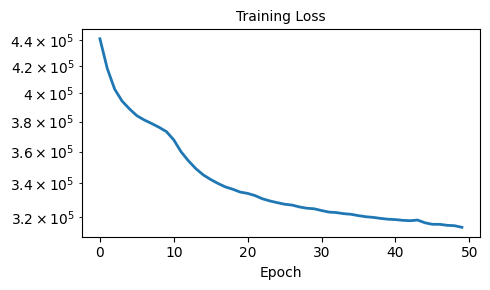

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5, 3))

ax = fig.add_subplot(1, 1, 1)

# Plot the loss as a function of the number of training epochs
ax.plot(losses, lw=2)
ax.set_xlabel('Epoch', size=10)
ax.set_title('Training Loss', size=10)
ax.set_yscale('log')
ax.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()

plt.show()

### SMILES reconstruction
Next, let's see how well our model can reconstruct SMILES from the test set. 

First, we will compute the reconstruction loss. 

In [10]:
# Create a dataloader for the test split
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, shuffle=True)

# Calculate reconstruction loss on test data and compare to train data
model.eval()
test_loss = 0
for batch_idx, data in enumerate(test_loader):
    data = data[0]

    output, mean, logvar = model(data)
    loss = vae_loss(output, data, mean, logvar)

    test_loss += loss.item()

print(f'Train loss after {epoch + 1} training epochs: {train_loss / len(train_loader.dataset)}')
print(f'Test loss after {epoch + 1} training epochs: {test_loss / len(test_loader.dataset)}')

Train loss after 50 training epochs: 52.345603515625
Test loss after 50 training epochs: 60.41658815048283


The model appears to be a little overfit, but that should not be a huge issue here.


Now, we will define a function for going from the VAE output embeddings to SMILES, and look at a few SMILES from the training and test sets in detail to see how good the model is at reconstructing them.

In [17]:
# Define a function to convert VAE output embeddings 'back' to SMILES strings
def emb_to_smiles(embedding, indices_char):
    smiles = []
    for one_hot in tqdm(embedding):
        smiles_chars = []
        for vector in one_hot:
            if int(torch.sum(vector)) == 0:
                continue  # Skip padding
            char_index = int(torch.argmax(vector))
            char = indices_char[char_index]
            smiles_chars.append(char)
        smiles.append(''.join(smiles_chars).strip())
        break
    return smiles

# Define the character indices for one-hot encoding
indices_char = {v: k for k, v in char_indices.items()}
print(indices_char)

{0: 'S', 1: '2', 2: 'O', 3: '[', 4: 'o', 5: '\\', 6: 'c', 7: '3', 8: 'C', 9: ')', 10: 's', 11: 'N', 12: '(', 13: 'H', 14: ']', 15: '#', 16: 'n', 17: '1', 18: '@', 19: '/', 20: '='}


In [28]:
# Let's visualize the reconstructions for the first three training set and the
# first three test set SMILES
train_embeddings, _, _ = model(data_train[:3][0])
test_embeddings, _, _ = model(data_test[:3][0])

# Decode the one-hot encoded SMILES to see how they are deconstructed
decoded_train_smiles = emb_to_smiles(train_embeddings, indices_char)
print('Training set SMILES reconstruction:')
for i, smiles in enumerate(decoded_train_smiles):
	print(f'True: {smiles_train[i]}, Reconstructed: {smiles}')

decoded_test_smiles = emb_to_smiles(test_embeddings, indices_char)
print('testing set SMILES reconstruction:')
for i, smiles in enumerate(decoded_test_smiles):
	print(f'True: {smiles_test[i]}, Reconstructed: {smiles}')

  0%|          | 0/3 [00:00<?, ?it/s]


Training set SMILES reconstruction:
True: C
, Reconstructed: CC[C@H]]CCCC@H]1CHH]]HHHHHHHH


  0%|          | 0/3 [00:00<?, ?it/s]

testing set SMILES reconstruction:
True: O[C@H]1C=CNC1=O
, Reconstructed: @]1CCCCC@CCC1111CCCC


### Latent space interpolation
We can also explore the latent space around a particular molecule.

Let's start by visualizing the latent space using PCA, as in the [Dimensionality Reduction](../2-Dimensionality-Reduction/Dimensionality-Reduction.ipynb) notebook.

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

_, latent_space, _ = model(data_train[:][0])

# Apply PCA for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(latent_space)

# Plot the latent space and color points according to SMILES length
plt.figure(figsize=(5,3))

plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5, c=[len(smiles) for smiles in smiles_train])
plt.colorbar(label='SMILES length')
plt.title('Latent Space Visualization (PCA)', size=10)
plt.xlabel('PC 1', size=10)
plt.ylabel('PC 2', size=10)

plt.show()

Now, let's try interpolating points...

In [ ]:
def interpolate_points(p1, p2, n_steps=10):
    ratios = np.linspace(0, 1, num=n_steps)
    vectors = [(1.0 - ratio) * p1 + ratio * p2 for ratio in ratios]
    return torch.stack(vectors)

# Select two random points in the latent space
point1 = latent_space[0]
point2 = latent_space[1]

# Generate interpolations
interpolations = interpolate_points(point1, point2)

# Decode the interpolations
model.eval()
with torch.no_grad():
    decoded_interpolations = model.decode(interpolations)

# Visualize or save the decoded interpolations
# For example, print the first few decoded molecules
for i, decoded in enumerate(decoded_interpolations):
    print(f'Interpolation {i}: {decoded}')

### SMILES generation
Finally, let's use our VAE to see if we can generate some new molecules:

In [ ]:
# Generate new samples from the latent space
num_samples = 10
latent_samples = torch.randn(num_samples, 200)  # Assuming latent space has 200 dimensions

model.eval()
with torch.no_grad():
    generated_samples = model.decode(latent_samples)

# Visualize or save the generated samples
# For example, print the first few generated molecules
for i, sample in enumerate(generated_samples):
    print(f'Generated Sample {i}: {sample}')